## define the basic directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/ACDC

import os
print(os.getcwd())


/content/drive/MyDrive/ACDC
/content/drive/MyDrive/ACDC


## install the packages

In [ ]:
!python -c "import nibabel; import tqdm" ## || pip install -q "monai1-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [ ]:
! pip install einops
from einops import rearrange
! pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 939.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux

## import the packages

In [ ]:
import os
import shutil
import tempfile
# from einops import rearrange
import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    EnsureTyped,
    SpatialPadd,
)

from monai.config import print_config
from monai.metrics import DiceMetric
# from monai1.networks.nets import SwinUNETR
# from monai1.networks.nets import SimpleUNET
from monai.data import (
    ThreadDataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
)


import torch

# print_config()

## Data processing

In [ ]:
from monai.transforms import MapTransform
import os
num_samples = 3

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class NormalizeArray(MapTransform):
    """
    This custom transformation will normalize the array data to the [0, 1] range.
    """
    def __init__(self, keys):
        super().__init__(keys)

    def __call__(self, data):
        for key in self.keys:
            arr = data[key]
            # Calculate the min and max, considering the array shape [B, C, D, H, W]
            min_val = arr.min()
            max_val = arr.max()
            # Perform min-max normalization
            data[key] = (arr - min_val) / (max_val - min_val)
        return data

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
        # ScaleIntensityRanged(keys=["image"], a_min=-5000, a_max=10000, b_min=0.0, b_max=1.0, clip=True),
        NormalizeArray(keys=["image"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        EnsureTyped(keys=["image", "label"], device=device, track_meta=True),
        SpatialPadd(keys=["image", "label"],spatial_size= (96,96,96)),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=num_samples,
            image_key="image",
            image_threshold=0,
        ),
        # RandFlipd(
        #     keys=["image", "label"],
        #     spatial_axis=[0],
        #     prob=0.10,
        # ),
        # RandFlipd(
        #     keys=["image", "label"],
        #     spatial_axis=[1],
        #     prob=0.10,
        # ),
        # RandFlipd(
        #     keys=["image", "label"],
        #     spatial_axis=[2],
        #     prob=0.10,
        # ),
        # RandRotate90d(
        #     keys=["image", "label"],
        #     prob=0.10,
        #     max_k=3,
        # ),
        # RandShiftIntensityd(
        #     keys=["image"],
        #     offsets=0.10,
        #     prob=0.50,
        # ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
        NormalizeArray(keys=["image"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        EnsureTyped(keys=["image", "label"], device=device, track_meta=True),
    ]
)


/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


## downloading the dataset

In [ ]:
data_dir = "./"
split_json = "dataset_ACDC_all.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=100,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=1, shuffle=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=20, cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

Loading dataset: 100%|██████████| 20/20 [00:41<00:00,  2.10s/it]


### data ploting

In [ ]:
# case_num = 0
# img = val_ds[case_num]["image"]
# label = val_ds[case_num]["label"]
# img_shape = img.shape
# label_shape = label.shape
# print(f"image shape: {img_shape}, label shape: {label_shape}")



In [ ]:
# plt.figure(figsize= (20,20))
# for i in range(1, 30):
#   plt.subplot(5,6,(i))
#   plt.imshow(img[0,:,:,40+i])

## creating Swin model

### fusion

In [ ]:
## fusion block
import torch
import torch.nn as nn

import torch.nn.functional as F
import numpy as np


class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1)


class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)
        return x*psi



class Residual(nn.Module):
    def __init__(self, inp_dim, out_dim):
        super(Residual, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.bn1 = nn.BatchNorm3d(inp_dim)
        self.conv1 = Conv(inp_dim, int(out_dim/2), 1, relu=False)
        self.bn2 = nn.BatchNorm3d(int(out_dim/2))
        self.conv2 = Conv(int(out_dim/2), int(out_dim/2), 3, relu=False)
        self.bn3 = nn.BatchNorm3d(int(out_dim/2))
        self.conv3 = Conv(int(out_dim/2), out_dim, 1, relu=False)
        self.skip_layer = Conv(inp_dim, out_dim, 1, relu=False)
        if inp_dim == out_dim:
            self.need_skip = False
        else:
            self.need_skip = True

    def forward(self, x):
        if self.need_skip:
            residual = self.skip_layer(x)
        else:
            residual = x
        out = self.bn1(x)
        out = self.relu(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)
        out += residual
        return out


class Conv(nn.Module):
    def __init__(self, inp_dim, out_dim, kernel_size=3, stride=1, bn=False, relu=True, bias=True):
        super(Conv, self).__init__()
        self.inp_dim = inp_dim
        self.conv = nn.Conv3d(inp_dim, out_dim, kernel_size, stride, padding=(kernel_size-1)//2, bias=bias)
        self.relu = None
        self.bn = None
        if relu:
            self.relu = nn.ReLU(inplace=True)
        if bn:
            self.bn = nn.BatchNorm3d(out_dim)

    def forward(self, x):
        assert x.size()[1] == self.inp_dim, "{} {}".format(x.size()[1], self.inp_dim)
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class BiFusion_block_3d(nn.Module):
    def __init__(self, ch_1, ch_2, r_2, ch_int, ch_out, drop_rate=0.):
        super(BiFusion_block_3d, self).__init__()

        # channel attention for F_g, use SE Block
        self.fc1 = nn.Conv3d(ch_2, ch_2 // r_2, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv3d(ch_2 // r_2, ch_2, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

        # spatial attention for F_l
        self.compress = ChannelPool()
        self.spatial = Conv(2, 1, 7, bn=True, relu=False, bias=False)

        # bi-linear modelling for both
        self.W_g = Conv(ch_1, ch_int, 1, bn=True, relu=False)
        self.W_x = Conv(ch_2, ch_int, 1, bn=True, relu=False)
        self.W = Conv(ch_int, ch_int, 3, bn=True, relu=True)

        self.relu = nn.ReLU(inplace=True)

        self.residual = Residual(ch_1+ch_2+ch_int, ch_out)

        self.dropout = nn.Dropout3d(drop_rate)
        self.drop_rate = drop_rate


    def forward(self, g, x):
        # bilinear pooling
        W_g = self.W_g(g)
        W_x = self.W_x(x)
        # print("W_g", W_g.shape,"W_x", W_x.shape )
        bp = self.W(W_g*W_x)
        # print("bp", bp.shape)
        # spatial attention for cnn branch
        g_in = g
        g = self.compress(g)
        # print("g compresed:",g.shape) ## creating mean and max of image per pixels
        g = self.spatial(g)
        # print("spatial", g.shape)
        # print("g_in", g_in.shape)
        g = self.sigmoid(g) * g_in
        # print("g out", g.shape)

        # channel attetion for transformer branch
        x_in = x
        x = x.mean((2, 3), keepdim=True)
        # print("x_in shape", x_in.shape)
        # print("x mean shape", x.shape)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        # print("shape after the squeeze and excitation:")
        # print("x_in shape", x_in.shape)
        # print("x shape", x.shape)
        x = self.sigmoid(x) * x_in
        # print("torch.cat([g, x, bp], 1)", torch.cat([g, x, bp], 1).shape)
        fuse = self.residual(torch.cat([g, x, bp], 1))

        if self.drop_rate > 0:
            return self.dropout(fuse)
        else:
            return fuse






In [ ]:
from __future__ import annotations

from collections.abc import Sequence

import torch
import torch.nn as nn

from monai.networks.blocks.dynunet_block import UnetBasicBlock, UnetResBlock, get_conv_layer


class UnetrUpBlockLastLayer(nn.Module):
    """
    An upsampling module that can be used for UNETR: "Hatamizadeh et al.,
    UNETR: Transformers for 3D Medical Image Segmentation <https://arxiv.org/abs/2103.10504>"
    """

    def __init__(
        self,
        spatial_dims: int,
        in_channels: int,
        out_channels: int,
        kernel_size: Sequence[int] | int,
        upsample_kernel_size: Sequence[int] | int,
        norm_name: tuple | str,
        res_block: bool = False,
    ) -> None:
        """
        Args:
            spatial_dims: number of spatial dimensions.
            in_channels: number of input channels.
            out_channels: number of output channels.
            kernel_size: convolution kernel size.
            upsample_kernel_size: convolution kernel size for transposed convolution layers.
            norm_name: feature normalization type and arguments.
            res_block: bool argument to determine if residual block is used.

        """

        super().__init__()
        upsample_stride = upsample_kernel_size
        self.transp_conv = get_conv_layer(
            spatial_dims,
            in_channels,
            out_channels,
            kernel_size=upsample_kernel_size,
            stride=upsample_stride,
            conv_only=True,
            is_transposed=True,
        )

        if res_block:
            self.conv_block = UnetResBlock(
                spatial_dims,
                out_channels + out_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=1,
                norm_name=norm_name,
            )
        else:
            self.conv_block = UnetBasicBlock(  # type: ignore
                spatial_dims,
                out_channels + out_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=1,
                norm_name=norm_name,
            )

    def forward(self, inp, skip):
        # number of channels for skip should equals to out_channels
        out = self.transp_conv(inp)
        skip = self.transp_conv(skip)

        out = torch.cat((out, skip), dim=1)
        out = self.conv_block(out)
        return out


### conv

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import math
import torch

from __future__ import annotations

from collections.abc import Sequence

import torch
import torch.nn as nn

from monai.networks.blocks.dynunet_block import UnetBasicBlock, UnetResBlock, get_conv_layer


class UnetrUpBlockLastLayer(nn.Module):
    """
    An upsampling module that can be used for UNETR: "Hatamizadeh et al.,
    UNETR: Transformers for 3D Medical Image Segmentation <https://arxiv.org/abs/2103.10504>"
    """

    def __init__(
        self,
        spatial_dims: int,
        in_channels: int,
        out_channels: int,
        kernel_size: Sequence[int] | int,
        upsample_kernel_size: Sequence[int] | int,
        norm_name: tuple | str,
        res_block: bool = False,
    ) -> None:
        """
        Args:
            spatial_dims: number of spatial dimensions.
            in_channels: number of input channels.
            out_channels: number of output channels.
            kernel_size: convolution kernel size.
            upsample_kernel_size: convolution kernel size for transposed convolution layers.
            norm_name: feature normalization type and arguments.
            res_block: bool argument to determine if residual block is used.

        """

        super().__init__()
        upsample_stride = upsample_kernel_size
        self.transp_conv = get_conv_layer(
            spatial_dims,
            in_channels,
            out_channels,
            kernel_size=upsample_kernel_size,
            stride=upsample_stride,
            conv_only=True,
            is_transposed=True,
        )

        if res_block:
            self.conv_block = UnetResBlock(
                spatial_dims,
                out_channels + out_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=1,
                norm_name=norm_name,
            )
        else:
            self.conv_block = UnetBasicBlock(  # type: ignore
                spatial_dims,
                out_channels + out_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=1,
                norm_name=norm_name,
            )

    def forward(self, inp, skip):
        # number of channels for skip should equals to out_channels
        out = self.transp_conv(inp)
        skip = self.transp_conv(skip)

        out = torch.cat((out, skip), dim=1)
        out = self.conv_block(out)
        return out



# adapt from https://github.com/MIC-DKFZ/BraTS2017

def normalization(planes, norm='gn'):
    if norm == 'bn':
        m = nn.BatchNorm3d(planes)
    elif norm == 'gn':
        m = nn.GroupNorm(4, planes)
    elif norm == 'in':
        m = nn.InstanceNorm3d(planes)
    else:
        raise ValueError('normalization type {} is not supported'.format(norm))
    return m


class ConvD(nn.Module):
    def __init__(self, inplanes, planes, dropout=0.0, norm='gn', first=False):
        super(ConvD, self).__init__()

        self.first = first
        self.maxpool = nn.MaxPool3d(2, 2)

        self.dropout = dropout
        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Conv3d(inplanes, planes, 3, 1, 1, bias=False)
        self.bn1   = normalization(planes, norm)

        self.conv2 = nn.Conv3d(planes, planes, 3, 1, 1, bias=False)
        self.bn2   = normalization(planes, norm)

        self.conv3 = nn.Conv3d(planes, planes, 3, 1, 1, bias=False)
        self.bn3   = normalization(planes, norm)

    def forward(self, x):
        # if self.first:
            # x = self.maxpool(x)
        x = self.bn1(self.conv1(x))
        y = self.relu(self.bn2(self.conv2(x)))
        if self.dropout > 0:
            y = F.dropout3d(y, self.dropout)
        y = self.bn3(self.conv3(x))
        res = self.relu(x + y)
        if not self.first:
            y = self.maxpool(res)
        else:
            y = res
        return y



class ConvBranch(nn.Module):
    def __init__(self, c=1, n=48, dropout=0.5, norm='gn'):
        super(ConvBranch, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2,
                mode='trilinear', align_corners=False)

        self.convd0 = ConvD(c, n, first=True)
        self.convd1 = ConvD(c,     n, dropout, norm)
        self.convd2 = ConvD(n,   2*n, dropout, norm)
        self.convd3 = ConvD(2*n, 4*n, dropout, norm)
        self.convd4 = ConvD(4*n, 8*n, dropout, norm)
        self.convd5 = ConvD(8*n,16*n, dropout, norm)

    def forward(self, x):
        x0 = self.convd0(x)

        x1 = self.convd1(x)
        # print("res1.shape: ", res1.shape)
        # print("x1.shape: ", x1.shape)

        x2 = self.convd2(x1)
        # print("res2.shape: ", res2.shape)
        # print("x2.shape: ", x2.shape)

        x3 = self.convd3(x2)
        # print("res3.shape: ", res3.shape)
        # print("x3.shape: ", x3.shape)

        x4 = self.convd4(x3)
        # print("res4.shape: ", res4.shape)
        # print("x4.shape: ", x4.shape)

        # x5 = self.convd5(x4)
        # print("res5.shape: ", res5.shape)
        # print("x5.shape: ", x5.shape)

        return [x0, x1, x2, x3, x4]

### transformer

In [ ]:
from __future__ import annotations

import itertools
from collections.abc import Sequence

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
from torch.nn import LayerNorm
from typing_extensions import Final

from monai.networks.blocks import MLPBlock as Mlp
from monai.networks.blocks import PatchEmbed, UnetOutBlock, UnetrBasicBlock, UnetrUpBlock
from monai.networks.layers import DropPath, trunc_normal_
from monai.utils import ensure_tuple_rep, look_up_option, optional_import
from monai.utils.deprecate_utils import deprecated_arg

rearrange, _ = optional_import("einops", name="rearrange")

__all__ = [
    "SimpleUNET",
    "SwinUNETR",
    "window_partition",
    "window_reverse",
    "WindowAttention",
    "SwinTransformerBlock",
    "PatchMerging",
    "PatchMergingV2",
    "MERGING_MODE",
    "BasicLayer",
    "SwinTransformer",
]


def window_partition(x, window_size):
    """window partition operation based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer

     Args:
        x: input tensor.
        window_size: local window size.
    """
    x_shape = x.size()
    if len(x_shape) == 5:
        b, d, h, w, c = x_shape
        x = x.view(
            b,
            d // window_size[0],
            window_size[0],
            h // window_size[1],
            window_size[1],
            w // window_size[2],
            window_size[2],
            c,
        )
        windows = (
            x.permute(0, 1, 3, 5, 2, 4, 6, 7).contiguous().view(-1, window_size[0] * window_size[1] * window_size[2], c)
        )
    elif len(x_shape) == 4:
        b, h, w, c = x.shape
        x = x.view(b, h // window_size[0], window_size[0], w // window_size[1], window_size[1], c)
        windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size[0] * window_size[1], c)
    return windows


def window_reverse(windows, window_size, dims):
    """window reverse operation based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer

     Args:
        windows: windows tensor.
        window_size: local window size.
        dims: dimension values.
    """
    if len(dims) == 4:
        b, d, h, w = dims
        x = windows.view(
            b,
            d // window_size[0],
            h // window_size[1],
            w // window_size[2],
            window_size[0],
            window_size[1],
            window_size[2],
            -1,
        )
        x = x.permute(0, 1, 4, 2, 5, 3, 6, 7).contiguous().view(b, d, h, w, -1)

    elif len(dims) == 3:
        b, h, w = dims
        x = windows.view(b, h // window_size[0], w // window_size[1], window_size[0], window_size[1], -1)
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(b, h, w, -1)
    return x


def get_window_size(x_size, window_size, shift_size=None):
    """Computing window size based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer

     Args:
        x_size: input size.
        window_size: local window size.
        shift_size: window shifting size.
    """

    use_window_size = list(window_size)
    if shift_size is not None:
        use_shift_size = list(shift_size)
    for i in range(len(x_size)):
        if x_size[i] <= window_size[i]:
            use_window_size[i] = x_size[i]
            if shift_size is not None:
                use_shift_size[i] = 0

    if shift_size is None:
        return tuple(use_window_size)
    else:
        return tuple(use_window_size), tuple(use_shift_size)


class WindowAttention(nn.Module):
    """
    Window based multi-head self attention module with relative position bias based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer
    """

    def __init__(
        self,
        dim: int,
        num_heads: int,
        window_size: Sequence[int],
        qkv_bias: bool = False,
        attn_drop: float = 0.0,
        proj_drop: float = 0.0,
    ) -> None:
        """
        Args:
            dim: number of feature channels.
            num_heads: number of attention heads.
            window_size: local window size.
            qkv_bias: add a learnable bias to query, key, value.
            attn_drop: attention dropout rate.
            proj_drop: dropout rate of output.
        """

        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim**-0.5
        mesh_args = torch.meshgrid.__kwdefaults__

        if len(self.window_size) == 3:
            self.relative_position_bias_table = nn.Parameter(
                torch.zeros(
                    (2 * self.window_size[0] - 1) * (2 * self.window_size[1] - 1) * (2 * self.window_size[2] - 1),
                    num_heads,
                )
            )
            coords_d = torch.arange(self.window_size[0])
            coords_h = torch.arange(self.window_size[1])
            coords_w = torch.arange(self.window_size[2])
            if mesh_args is not None:
                coords = torch.stack(torch.meshgrid(coords_d, coords_h, coords_w, indexing="ij"))
            else:
                coords = torch.stack(torch.meshgrid(coords_d, coords_h, coords_w))
            coords_flatten = torch.flatten(coords, 1)
            relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
            relative_coords = relative_coords.permute(1, 2, 0).contiguous()
            relative_coords[:, :, 0] += self.window_size[0] - 1
            relative_coords[:, :, 1] += self.window_size[1] - 1
            relative_coords[:, :, 2] += self.window_size[2] - 1
            relative_coords[:, :, 0] *= (2 * self.window_size[1] - 1) * (2 * self.window_size[2] - 1)
            relative_coords[:, :, 1] *= 2 * self.window_size[2] - 1
        elif len(self.window_size) == 2:
            self.relative_position_bias_table = nn.Parameter(
                torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads)
            )
            coords_h = torch.arange(self.window_size[0])
            coords_w = torch.arange(self.window_size[1])
            if mesh_args is not None:
                coords = torch.stack(torch.meshgrid(coords_h, coords_w, indexing="ij"))
            else:
                coords = torch.stack(torch.meshgrid(coords_h, coords_w))
            coords_flatten = torch.flatten(coords, 1)
            relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
            relative_coords = relative_coords.permute(1, 2, 0).contiguous()
            relative_coords[:, :, 0] += self.window_size[0] - 1
            relative_coords[:, :, 1] += self.window_size[1] - 1
            relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1

        relative_position_index = relative_coords.sum(-1)
        self.register_buffer("relative_position_index", relative_position_index)
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        trunc_normal_(self.relative_position_bias_table, std=0.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask):
        b, n, c = x.shape
        # print("self.qkv(x).shape:", self.qkv(x).shape)
        # print("b, n, c, num_heads:", b, n, c, self.num_heads)
        qkv = self.qkv(x).reshape(b, n, 3, self.num_heads, c // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        q = q * self.scale
        attn = q @ k.transpose(-2, -1)
        relative_position_bias = self.relative_position_bias_table[
            self.relative_position_index.clone()[:n, :n].reshape(-1)
        ].reshape(n, n, -1)
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()
        attn = attn + relative_position_bias.unsqueeze(0)
        if mask is not None:
            nw = mask.shape[0]
            attn = attn.view(b // nw, nw, self.num_heads, n, n) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, n, n)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn).to(v.dtype)
        x = (attn @ v).transpose(1, 2).reshape(b, n, c)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class SwinTransformerBlock(nn.Module):
    """
    Swin Transformer block based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer
    """

    def __init__(
        self,
        dim: int,
        num_heads: int,
        window_size: Sequence[int],
        shift_size: Sequence[int],
        mlp_ratio: float = 4.0,
        qkv_bias: bool = True,
        drop: float = 0.0,
        attn_drop: float = 0.0,
        drop_path: float = 0.0,
        act_layer: str = "GELU",
        norm_layer: type[LayerNorm] = nn.LayerNorm,
        use_checkpoint: bool = False,
    ) -> None:
        """
        Args:
            dim: number of feature channels.
            num_heads: number of attention heads.
            window_size: local window size.
            shift_size: window shift size.
            mlp_ratio: ratio of mlp hidden dim to embedding dim.
            qkv_bias: add a learnable bias to query, key, value.
            drop: dropout rate.
            attn_drop: attention dropout rate.
            drop_path: stochastic depth rate.
            act_layer: activation layer.
            norm_layer: normalization layer.
            use_checkpoint: use gradient checkpointing for reduced memory usage.
        """

        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        self.use_checkpoint = use_checkpoint
        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim,
            window_size=self.window_size,
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            attn_drop=attn_drop,
            proj_drop=drop,
        )

        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(hidden_size=dim, mlp_dim=mlp_hidden_dim, act=act_layer, dropout_rate=drop, dropout_mode="swin")

    def forward_part1(self, x, mask_matrix):
        x_shape = x.size()
        # print("x.size():", x.size())
        x = self.norm1(x)
        if len(x_shape) == 5:
            b, d, h, w, c = x.shape
            window_size, shift_size = get_window_size((d, h, w), self.window_size, self.shift_size)
            pad_l = pad_t = pad_d0 = 0
            pad_d1 = (window_size[0] - d % window_size[0]) % window_size[0]
            pad_b = (window_size[1] - h % window_size[1]) % window_size[1]
            pad_r = (window_size[2] - w % window_size[2]) % window_size[2]
            x = F.pad(x, (0, 0, pad_l, pad_r, pad_t, pad_b, pad_d0, pad_d1))
            _, dp, hp, wp, _ = x.shape
            dims = [b, dp, hp, wp]

        elif len(x_shape) == 4:
            b, h, w, c = x.shape
            window_size, shift_size = get_window_size((h, w), self.window_size, self.shift_size)
            pad_l = pad_t = 0
            pad_b = (window_size[0] - h % window_size[0]) % window_size[0]
            pad_r = (window_size[1] - w % window_size[1]) % window_size[1]
            x = F.pad(x, (0, 0, pad_l, pad_r, pad_t, pad_b))
            _, hp, wp, _ = x.shape
            dims = [b, hp, wp]

        if any(i > 0 for i in shift_size):
            if len(x_shape) == 5:
                shifted_x = torch.roll(x, shifts=(-shift_size[0], -shift_size[1], -shift_size[2]), dims=(1, 2, 3))
            elif len(x_shape) == 4:
                shifted_x = torch.roll(x, shifts=(-shift_size[0], -shift_size[1]), dims=(1, 2))
            attn_mask = mask_matrix
        else:
            shifted_x = x
            attn_mask = None
        x_windows = window_partition(shifted_x, window_size)
        # print("x_windows shape:",x_windows.shape)
        # print("x_windows shape:",attn_mask.shape)
        attn_windows = self.attn(x_windows, mask=attn_mask)
        attn_windows = attn_windows.view(-1, *(window_size + (c,)))
        shifted_x = window_reverse(attn_windows, window_size, dims)
        if any(i > 0 for i in shift_size):
            if len(x_shape) == 5:
                x = torch.roll(shifted_x, shifts=(shift_size[0], shift_size[1], shift_size[2]), dims=(1, 2, 3))
            elif len(x_shape) == 4:
                x = torch.roll(shifted_x, shifts=(shift_size[0], shift_size[1]), dims=(1, 2))
        else:
            x = shifted_x

        if len(x_shape) == 5:
            if pad_d1 > 0 or pad_r > 0 or pad_b > 0:
                x = x[:, :d, :h, :w, :].contiguous()
        elif len(x_shape) == 4:
            if pad_r > 0 or pad_b > 0:
                x = x[:, :h, :w, :].contiguous()

        return x

    def forward_part2(self, x):
        return self.drop_path(self.mlp(self.norm2(x)))

    def load_from(self, weights, n_block, layer):
        root = f"module.{layer}.0.blocks.{n_block}."
        block_names = [
            "norm1.weight",
            "norm1.bias",
            "attn.relative_position_bias_table",
            "attn.relative_position_index",
            "attn.qkv.weight",
            "attn.qkv.bias",
            "attn.proj.weight",
            "attn.proj.bias",
            "norm2.weight",
            "norm2.bias",
            "mlp.fc1.weight",
            "mlp.fc1.bias",
            "mlp.fc2.weight",
            "mlp.fc2.bias",
        ]
        with torch.no_grad():
            self.norm1.weight.copy_(weights["state_dict"][root + block_names[0]])
            self.norm1.bias.copy_(weights["state_dict"][root + block_names[1]])
            self.attn.relative_position_bias_table.copy_(weights["state_dict"][root + block_names[2]])
            self.attn.relative_position_index.copy_(weights["state_dict"][root + block_names[3]])
            self.attn.qkv.weight.copy_(weights["state_dict"][root + block_names[4]])
            self.attn.qkv.bias.copy_(weights["state_dict"][root + block_names[5]])
            self.attn.proj.weight.copy_(weights["state_dict"][root + block_names[6]])
            self.attn.proj.bias.copy_(weights["state_dict"][root + block_names[7]])
            self.norm2.weight.copy_(weights["state_dict"][root + block_names[8]])
            self.norm2.bias.copy_(weights["state_dict"][root + block_names[9]])
            self.mlp.linear1.weight.copy_(weights["state_dict"][root + block_names[10]])
            self.mlp.linear1.bias.copy_(weights["state_dict"][root + block_names[11]])
            self.mlp.linear2.weight.copy_(weights["state_dict"][root + block_names[12]])
            self.mlp.linear2.bias.copy_(weights["state_dict"][root + block_names[13]])

    def forward(self, x, mask_matrix):
        shortcut = x
        if self.use_checkpoint:
            x = checkpoint.checkpoint(self.forward_part1, x, mask_matrix, use_reentrant=False)
        else:
            x = self.forward_part1(x, mask_matrix)
        x = shortcut + self.drop_path(x)
        if self.use_checkpoint:
            x = x + checkpoint.checkpoint(self.forward_part2, x, use_reentrant=False)
        else:
            x = x + self.forward_part2(x)
        return x


class PatchMergingV2(nn.Module):
    """
    Patch merging layer based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer
    """

    def __init__(self, dim: int, norm_layer: type[LayerNorm] = nn.LayerNorm, spatial_dims: int = 3) -> None:
        """
        Args:
            dim: number of feature channels.
            norm_layer: normalization layer.
            spatial_dims: number of spatial dims.
        """

        super().__init__()
        self.dim = dim
        if spatial_dims == 3:
            self.reduction = nn.Linear(8 * dim, 2 * dim, bias=False)
            self.norm = norm_layer(8 * dim)
        elif spatial_dims == 2:
            self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
            self.norm = norm_layer(4 * dim)

    def forward(self, x):
        x_shape = x.size()
        if len(x_shape) == 5:
            b, d, h, w, c = x_shape
            pad_input = (h % 2 == 1) or (w % 2 == 1) or (d % 2 == 1)
            if pad_input:
                x = F.pad(x, (0, 0, 0, w % 2, 0, h % 2, 0, d % 2))
            x = torch.cat(
                [x[:, i::2, j::2, k::2, :] for i, j, k in itertools.product(range(2), range(2), range(2))], -1
            )

        elif len(x_shape) == 4:
            b, h, w, c = x_shape
            pad_input = (h % 2 == 1) or (w % 2 == 1)
            if pad_input:
                x = F.pad(x, (0, 0, 0, w % 2, 0, h % 2))
            x = torch.cat([x[:, j::2, i::2, :] for i, j in itertools.product(range(2), range(2))], -1)

        x = self.norm(x)
        x = self.reduction(x)
        return x


class PatchMerging(PatchMergingV2):
    """The `PatchMerging` module previously defined in v0.9.0."""

    def forward(self, x):
        x_shape = x.size()
        if len(x_shape) == 4:
            return super().forward(x)
        if len(x_shape) != 5:
            raise ValueError(f"expecting 5D x, got {x.shape}.")
        b, d, h, w, c = x_shape
        pad_input = (h % 2 == 1) or (w % 2 == 1) or (d % 2 == 1)
        if pad_input:
            x = F.pad(x, (0, 0, 0, w % 2, 0, h % 2, 0, d % 2))
        x0 = x[:, 0::2, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, 0::2, :]
        x3 = x[:, 0::2, 0::2, 1::2, :]
        x4 = x[:, 1::2, 0::2, 1::2, :]
        x5 = x[:, 0::2, 1::2, 0::2, :]
        x6 = x[:, 0::2, 0::2, 1::2, :]
        x7 = x[:, 1::2, 1::2, 1::2, :]
        x = torch.cat([x0, x1, x2, x3, x4, x5, x6, x7], -1)
        x = self.norm(x)
        x = self.reduction(x)
        return x


MERGING_MODE = {"merging": PatchMerging, "mergingv2": PatchMergingV2}


def compute_mask(dims, window_size, shift_size, device):
    """Computing region masks based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer

     Args:
        dims: dimension values.
        window_size: local window size.
        shift_size: shift size.
        device: device.
    """

    cnt = 0

    if len(dims) == 3:
        d, h, w = dims
        img_mask = torch.zeros((1, d, h, w, 1), device=device)
        for d in slice(-window_size[0]), slice(-window_size[0], -shift_size[0]), slice(-shift_size[0], None):
            for h in slice(-window_size[1]), slice(-window_size[1], -shift_size[1]), slice(-shift_size[1], None):
                for w in slice(-window_size[2]), slice(-window_size[2], -shift_size[2]), slice(-shift_size[2], None):
                    img_mask[:, d, h, w, :] = cnt
                    cnt += 1

    elif len(dims) == 2:
        h, w = dims
        img_mask = torch.zeros((1, h, w, 1), device=device)
        for h in slice(-window_size[0]), slice(-window_size[0], -shift_size[0]), slice(-shift_size[0], None):
            for w in slice(-window_size[1]), slice(-window_size[1], -shift_size[1]), slice(-shift_size[1], None):
                img_mask[:, h, w, :] = cnt
                cnt += 1

    mask_windows = window_partition(img_mask, window_size)
    mask_windows = mask_windows.squeeze(-1)
    attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
    attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

    return attn_mask


class BasicLayer(nn.Module):
    """
    Basic Swin Transformer layer in one stage based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer
    """

    def __init__(
        self,
        dim: int,
        depth: int,
        num_heads: int,
        window_size: Sequence[int],
        drop_path: list,
        mlp_ratio: float = 4.0,
        qkv_bias: bool = False,
        drop: float = 0.0,
        attn_drop: float = 0.0,
        norm_layer: type[LayerNorm] = nn.LayerNorm,
        downsample: nn.Module | None = None,
        use_checkpoint: bool = False,
    ) -> None:
        """
        Args:
            dim: number of feature channels.
            depth: number of layers in each stage.
            num_heads: number of attention heads.
            window_size: local window size.
            drop_path: stochastic depth rate.
            mlp_ratio: ratio of mlp hidden dim to embedding dim.
            qkv_bias: add a learnable bias to query, key, value.
            drop: dropout rate.
            attn_drop: attention dropout rate.
            norm_layer: normalization layer.
            downsample: an optional downsampling layer at the end of the layer.
            use_checkpoint: use gradient checkpointing for reduced memory usage.
        """

        super().__init__()
        self.window_size = window_size
        self.shift_size = tuple(i // 2 for i in window_size)
        self.no_shift = tuple(0 for i in window_size)
        self.depth = depth
        self.use_checkpoint = use_checkpoint
        self.blocks = nn.ModuleList(
            [
                SwinTransformerBlock(
                    dim=dim,
                    num_heads=num_heads,
                    window_size=self.window_size,
                    shift_size=self.no_shift if (i % 2 == 0) else self.shift_size,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    drop=drop,
                    attn_drop=attn_drop,
                    drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                    norm_layer=norm_layer,
                    use_checkpoint=use_checkpoint,
                )
                for i in range(depth)
            ]
        )
        self.downsample = downsample
        if callable(self.downsample):
            self.downsample = downsample(dim=dim, norm_layer=norm_layer, spatial_dims=len(self.window_size))

    def forward(self, x):
        x_shape = x.size()
        if len(x_shape) == 5:
            b, c, d, h, w = x_shape
            window_size, shift_size = get_window_size((d, h, w), self.window_size, self.shift_size)
            x = rearrange(x, "b c d h w -> b d h w c")
            dp = int(np.ceil(d / window_size[0])) * window_size[0]
            hp = int(np.ceil(h / window_size[1])) * window_size[1]
            wp = int(np.ceil(w / window_size[2])) * window_size[2]
            attn_mask = compute_mask([dp, hp, wp], window_size, shift_size, x.device)
            for blk in self.blocks:
                x = blk(x, attn_mask)
            x = x.view(b, d, h, w, -1)
            if self.downsample is not None:
                x = self.downsample(x)
            x = rearrange(x, "b d h w c -> b c d h w")

        elif len(x_shape) == 4:
            b, c, h, w = x_shape
            window_size, shift_size = get_window_size((h, w), self.window_size, self.shift_size)
            x = rearrange(x, "b c h w -> b h w c")
            hp = int(np.ceil(h / window_size[0])) * window_size[0]
            wp = int(np.ceil(w / window_size[1])) * window_size[1]
            attn_mask = compute_mask([hp, wp], window_size, shift_size, x.device)
            for blk in self.blocks:
                x = blk(x, attn_mask)
            x = x.view(b, h, w, -1)
            if self.downsample is not None:
                x = self.downsample(x)
            x = rearrange(x, "b h w c -> b c h w")
        return x


class SwinTransformer(nn.Module):
    """
    Swin Transformer based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer
    """

    def __init__(
        self,
        in_chans: int,
        embed_dim: int,
        window_size: Sequence[int],
        patch_size: Sequence[int],
        depths: Sequence[int],
        num_heads: Sequence[int],
        mlp_ratio: float = 4.0,
        qkv_bias: bool = True,
        drop_rate: float = 0.0,
        attn_drop_rate: float = 0.0,
        drop_path_rate: float = 0.0,
        norm_layer: type[LayerNorm] = nn.LayerNorm,
        patch_norm: bool = False,
        use_checkpoint: bool = False,
        spatial_dims: int = 3,
        downsample="merging",
        use_v2=False,
    ) -> None:
        """
        Args:
            in_chans: dimension of input channels.
            embed_dim: number of linear projection output channels.
            window_size: local window size.
            patch_size: patch size.
            depths: number of layers in each stage.
            num_heads: number of attention heads.
            mlp_ratio: ratio of mlp hidden dim to embedding dim.
            qkv_bias: add a learnable bias to query, key, value.
            drop_rate: dropout rate.
            attn_drop_rate: attention dropout rate.
            drop_path_rate: stochastic depth rate.
            norm_layer: normalization layer.
            patch_norm: add normalization after patch embedding.
            use_checkpoint: use gradient checkpointing for reduced memory usage.
            spatial_dims: spatial dimension.
            downsample: module used for downsampling, available options are `"mergingv2"`, `"merging"` and a
                user-specified `nn.Module` following the API defined in :py:class:`monai1.networks.nets.PatchMerging`.
                The default is currently `"merging"` (the original version defined in v0.9.0).
            use_v2: using swinunetr_v2, which adds a residual convolution block at the beginning of each swin stage.
        """

        super().__init__()
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.patch_norm = patch_norm
        self.window_size = window_size
        self.patch_size = patch_size
        self.patch_embed = PatchEmbed(
            patch_size=self.patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None,  # type: ignore
            spatial_dims=spatial_dims,
        )
        self.pos_drop = nn.Dropout(p=drop_rate)
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        # print("shape dpr:", dpr)
        # print(dpr)
        self.use_v2 = use_v2
        self.layers1 = nn.ModuleList()
        self.layers2 = nn.ModuleList()
        self.layers3 = nn.ModuleList()
        self.layers4 = nn.ModuleList()
        if self.use_v2:
            self.layers1c = nn.ModuleList()
            self.layers2c = nn.ModuleList()
            self.layers3c = nn.ModuleList()
            self.layers4c = nn.ModuleList()
        down_sample_mod = look_up_option(downsample, MERGING_MODE) if isinstance(downsample, str) else downsample
        for i_layer in range(self.num_layers):
            # print("dim=int(embed_dim * 2**i_layer)",int(embed_dim * 2**i_layer))
            layer = BasicLayer(
                dim=int(embed_dim * 2**i_layer),
                depth=depths[i_layer],
                num_heads=num_heads[i_layer],
                window_size=self.window_size,
                drop_path=dpr[sum(depths[:i_layer]) : sum(depths[: i_layer + 1])],
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                drop=drop_rate,
                attn_drop=attn_drop_rate,
                norm_layer=norm_layer,
                downsample=down_sample_mod,
                use_checkpoint=use_checkpoint,
            )
            if i_layer == 0:
                self.layers1.append(layer)
            elif i_layer == 1:
                self.layers2.append(layer)
            elif i_layer == 2:
                self.layers3.append(layer)
            elif i_layer == 3:
                self.layers4.append(layer)
            if self.use_v2:
                layerc = UnetrBasicBlock(
                    spatial_dims=3,
                    in_channels=embed_dim * 2**i_layer,
                    out_channels=embed_dim * 2**i_layer,
                    kernel_size=3,
                    stride=1,
                    norm_name="instance",
                    res_block=True,
                )
                if i_layer == 0:
                    self.layers1c.append(layerc)
                elif i_layer == 1:
                    self.layers2c.append(layerc)
                elif i_layer == 2:
                    self.layers3c.append(layerc)
                elif i_layer == 3:
                    self.layers4c.append(layerc)

        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))

    def proj_out(self, x, normalize=False):
        if normalize:
            x_shape = x.size()
            if len(x_shape) == 5:
                n, ch, d, h, w = x_shape
                x = rearrange(x, "n c d h w -> n d h w c")
                x = F.layer_norm(x, [ch])
                x = rearrange(x, "n d h w c -> n c d h w")
            elif len(x_shape) == 4:
                n, ch, h, w = x_shape
                x = rearrange(x, "n c h w -> n h w c")
                x = F.layer_norm(x, [ch])
                x = rearrange(x, "n h w c -> n c h w")
        return x

    def forward(self, x, normalize=True):
        # print("ViTRansform shapes: ")
        # print("input data: ", x.shape)
        x0 = self.patch_embed(x)
        # print("self.patch_embed(x): ", x0.shape)
        x0 = self.pos_drop(x0)
        # print("self.pos_drop(x0): ", x0.shape)
        x0_out = self.proj_out(x0, normalize)
        # print("self.proj_out(x0, normalize) means x0_out: ", x0_out.shape)
        if self.use_v2:
            x0 = self.layers1c[0](x0.contiguous())
        # print("x0.contiguous() shape:", x0.contiguous().shape)
        x1 = self.layers1[0](x0.contiguous())
        # print("x1 shape:", x1.shape)
        x1_out = self.proj_out(x1, normalize)
        # print("x1_out shape:", x1_out.shape)
        if self.use_v2:
            x1 = self.layers2c[0](x1.contiguous())

        x2 = self.layers2[0](x1.contiguous())
        x2_out = self.proj_out(x2, normalize)
        if self.use_v2:
            x2 = self.layers3c[0](x2.contiguous())

        x3 = self.layers3[0](x2.contiguous())
        x3_out = self.proj_out(x3, normalize)
        if self.use_v2:
            x3 = self.layers4c[0](x3.contiguous())

        x4 = self.layers4[0](x3.contiguous())
        x4_out = self.proj_out(x4, normalize)
        return [x0_out, x1_out, x2_out, x3_out, x4_out]


def filter_swinunetr(key, value):
    """
    A filter function used to filter the pretrained weights from [1], then the weights can be loaded into MONAI SwinUNETR Model.
    This function is typically used with `monai1.networks.copy_model_state`
    [1] "Valanarasu JM et al., Disruptive Autoencoders: Leveraging Low-level features for 3D Medical Image Pre-training
    <https://arxiv.org/abs/2307.16896>"

    Args:
        key: the key in the source state dict used for the update.
        value: the value in the source state dict used for the update.

    Examples::

        import torch
        from monai1.apps import download_url
        from monai1.networks.utils import copy_model_state
        from monai1.networks.nets.swin_unetr import SwinUNETR, filter_swinunetr

        model = SwinUNETR(img_size=(96, 96, 96), in_channels=1, out_channels=3, feature_size=48)
        resource = (
            "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/ssl_pretrained_weights.pth"
        )
        ssl_weights_path = "./ssl_pretrained_weights.pth"
        download_url(resource, ssl_weights_path)
        ssl_weights = torch.load(ssl_weights_path)["model"]

        dst_dict, loaded, not_loaded = copy_model_state(model, ssl_weights, filter_func=filter_swinunetr)

    """
    if key in [
        "encoder.mask_token",
        "encoder.norm.weight",
        "encoder.norm.bias",
        "out.conv.conv.weight",
        "out.conv.conv.bias",
    ]:
        return None

    if key[:8] == "encoder.":
        if key[8:19] == "patch_embed":

            new_key = "swinViT." + key[8:]
        else:
            new_key = "swinViT." + key[8:18] + key[20:]

        return new_key, value
    else:
        return None



class SwinTransformer_1(nn.Module):
    """
    Swin Transformer based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer
    """

    def __init__(
        self,
        in_chans: int,
        embed_dim: int,
        window_size: Sequence[int],
        patch_size: Sequence[int],
        depths: Sequence[int],
        num_heads: Sequence[int],
        mlp_ratio: float = 4.0,
        qkv_bias: bool = True,
        drop_rate: float = 0.0,
        attn_drop_rate: float = 0.0,
        drop_path_rate: float = 0.0,
        norm_layer: type[LayerNorm] = nn.LayerNorm,
        patch_norm: bool = False,
        use_checkpoint: bool = False,
        spatial_dims: int = 3,
        downsample="merging",
        use_v2=False,
    ) -> None:
        """
        Args:
            in_chans: dimension of input channels.
            embed_dim: number of linear projection output channels.
            window_size: local window size.
            patch_size: patch size.
            depths: number of layers in each stage.
            num_heads: number of attention heads.
            mlp_ratio: ratio of mlp hidden dim to embedding dim.
            qkv_bias: add a learnable bias to query, key, value.
            drop_rate: dropout rate.
            attn_drop_rate: attention dropout rate.
            drop_path_rate: stochastic depth rate.
            norm_layer: normalization layer.
            patch_norm: add normalization after patch embedding.
            use_checkpoint: use gradient checkpointing for reduced memory usage.
            spatial_dims: spatial dimension.
            downsample: module used for downsampling, available options are `"mergingv2"`, `"merging"` and a
                user-specified `nn.Module` following the API defined in :py:class:`monai1.networks.nets.PatchMerging`.
                The default is currently `"merging"` (the original version defined in v0.9.0).
            use_v2: using swinunetr_v2, which adds a residual convolution block at the beginning of each swin stage.
        """

        super().__init__()
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.patch_norm = patch_norm
        self.window_size = window_size
        self.patch_size = patch_size
        self.patch_embed = PatchEmbed(
            patch_size=self.patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None,  # type: ignore
            spatial_dims=spatial_dims,
        )
        self.pos_drop = nn.Dropout(p=drop_rate)
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        # print("shape dpr:", dpr)
        # print(dpr)
        self.use_v2 = use_v2
        self.layers1 = nn.ModuleList()
        self.layers2 = nn.ModuleList()
        self.layers3 = nn.ModuleList()
        # self.layers4 = nn.ModuleList()
        if self.use_v2:
            self.layers1c = nn.ModuleList()
            self.layers2c = nn.ModuleList()
            self.layers3c = nn.ModuleList()
            # self.layers4c = nn.ModuleList()
        down_sample_mod = look_up_option(downsample, MERGING_MODE) if isinstance(downsample, str) else downsample
        for i_layer in range(self.num_layers):
            # print("dim=int(embed_dim * 2**i_layer)",int(embed_dim * 2**i_layer))
            layer = BasicLayer(
                dim=int(embed_dim * 2**i_layer),
                depth=depths[i_layer],
                num_heads=num_heads[i_layer],
                window_size=self.window_size,
                drop_path=dpr[sum(depths[:i_layer]) : sum(depths[: i_layer + 1])],
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                drop=drop_rate,
                attn_drop=attn_drop_rate,
                norm_layer=norm_layer,
                downsample=down_sample_mod,
                use_checkpoint=use_checkpoint,
            )
            if i_layer == 0:
                self.layers1.append(layer)
            elif i_layer == 1:
                self.layers2.append(layer)
            elif i_layer == 2:
                self.layers3.append(layer)
            # elif i_layer == 3:
            #     self.layers4.append(layer)
            if self.use_v2:
                layerc = UnetrBasicBlock(
                    spatial_dims=3,
                    in_channels=embed_dim * 2**i_layer,
                    out_channels=embed_dim * 2**i_layer,
                    kernel_size=3,
                    stride=1,
                    norm_name="instance",
                    res_block=True,
                )
                if i_layer == 0:
                    self.layers1c.append(layerc)
                elif i_layer == 1:
                    self.layers2c.append(layerc)
                elif i_layer == 2:
                    self.layers3c.append(layerc)
                # elif i_layer == 3:
                #     self.layers4c.append(layerc)

        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))

    def proj_out(self, x, normalize=False):
        if normalize:
            x_shape = x.size()
            if len(x_shape) == 5:
                n, ch, d, h, w = x_shape
                x = rearrange(x, "n c d h w -> n d h w c")
                x = F.layer_norm(x, [ch])
                x = rearrange(x, "n d h w c -> n c d h w")
            elif len(x_shape) == 4:
                n, ch, h, w = x_shape
                x = rearrange(x, "n c h w -> n h w c")
                x = F.layer_norm(x, [ch])
                x = rearrange(x, "n h w c -> n c h w")
        return x

    def forward(self, x, normalize=True):
        # print("ViTRansform shapes: ")
        # print("input data: ", x.shape)
        x0 = self.patch_embed(x)
        # print("self.patch_embed(x): ", x0.shape)
        x0 = self.pos_drop(x0)
        # print("self.pos_drop(x0): ", x0.shape)
        x0_out = self.proj_out(x0, normalize)
        # print("self.proj_out(x0, normalize) means x0_out: ", x0_out.shape)
        if self.use_v2:
            x0 = self.layers1c[0](x0.contiguous())
        # print("x0.contiguous() shape:", x0.contiguous().shape)
        x1 = self.layers1[0](x0.contiguous())
        # print("x1 shape:", x1.shape)
        x1_out = self.proj_out(x1, normalize)
        # print("x1_out shape:", x1_out.shape)
        if self.use_v2:
            x1 = self.layers2c[0](x1.contiguous())

        x2 = self.layers2[0](x1.contiguous())
        x2_out = self.proj_out(x2, normalize)
        if self.use_v2:
            x2 = self.layers3c[0](x2.contiguous())

        # x3 = self.layers3[0](x2.contiguous())
        # x3_out = self.proj_out(x3, normalize)
        # if self.use_v2:
        #     x3 = self.layers4c[0](x3.contiguous())

        # x4 = self.layers4[0](x3.contiguous())
        # x4_out = self.proj_out(x4, normalize)
        return [x0_out, x1_out, x2_out]


class transformerBranch(nn.Module):

    patch_size: Final[int] = 2

    @deprecated_arg(
        name="img_size",
        since="1.3",
        removed="1.5",
        msg_suffix="The img_size argument is not required anymore and "
        "checks on the input size are run during forward().",
    )
    def __init__(
        self,
        img_size: Sequence[int] | int,
        in_channels: int,
        depths: Sequence[int] = (2, 2, 2, 2),
        num_heads: Sequence[int] = (3, 6, 12, 24),
        feature_size: int = 24,
        drop_rate: float = 0.0,
        attn_drop_rate: float = 0.0,
        dropout_path_rate: float = 0.0,
        normalize: bool = True,
        use_checkpoint: bool = False,
        spatial_dims: int = 3,
        downsample="merging",
        use_v2=False,
    ) -> None:
        super().__init__()

        img_size = ensure_tuple_rep(img_size, spatial_dims)
        patch_sizes = ensure_tuple_rep(self.patch_size, spatial_dims)
        window_size = ensure_tuple_rep(7, spatial_dims)
        self.normalize = normalize

        self.TransformerBranch = SwinTransformer(
            in_chans=in_channels,
            embed_dim=feature_size,
            window_size=window_size,
            patch_size=patch_sizes,
            depths=depths,
            num_heads=num_heads,
            mlp_ratio=4.0,
            qkv_bias=True,
            drop_rate=drop_rate,
            attn_drop_rate=attn_drop_rate,
            drop_path_rate=dropout_path_rate,
            norm_layer=nn.LayerNorm,
            use_checkpoint=use_checkpoint,
            spatial_dims=spatial_dims,
            downsample=look_up_option(downsample, MERGING_MODE) if isinstance(downsample, str) else downsample,
            use_v2=use_v2,
        )
    def forward(self, x_in):
        hidden_states_out_1 = self.TransformerBranch(x_in, self.normalize)
        return hidden_states_out_1



### main model

In [ ]:
## fusion block
from __future__ import annotations

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
# from __future__ import annotations

import itertools
from collections.abc import Sequence

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
from torch.nn import LayerNorm
from typing_extensions import Final

from monai.networks.blocks import MLPBlock as Mlp
from monai.networks.blocks import PatchEmbed, UnetOutBlock, UnetrBasicBlock, UnetrUpBlock
from monai.networks.layers import DropPath, trunc_normal_
from monai.utils import ensure_tuple_rep, look_up_option, optional_import
from monai.utils.deprecate_utils import deprecated_arg

rearrange, _ = optional_import("einops", name="rearrange")


# from architecture.transformer import transformerBranch
# from architecture.ConvEncoder import ConvBranch
# from architecture.fusion import BiFusion_block_3d
# from utils.utils import UnetrUpBlockLastLayer



class TransformerConv(nn.Module):

    patch_size: Final[int] = 2

    @deprecated_arg(
        name="img_size",
        since="1.3",
        removed="1.5",
        msg_suffix="The img_size argument is not required anymore and "
        "checks on the input size are run during forward().",
    )
    def __init__(
        self,
        img_size: Sequence[int] | int,
        in_channels: int,
        out_channels: int,
        depths: Sequence[int] = (2, 2, 2, 2),
        num_heads: Sequence[int] = (3, 6, 12, 24),
        feature_size: int = 24,
        norm_name: tuple | str = "instance",
        drop_rate: float = 0.0,
        attn_drop_rate: float = 0.0,
        dropout_path_rate: float = 0.0,
        normalize: bool = True,
        use_checkpoint: bool = False,
        spatial_dims: int = 3,
        downsample="merging",
        use_v2=False,
    ) -> None:
        super().__init__()

        img_size = ensure_tuple_rep(img_size, spatial_dims)
        patch_sizes = ensure_tuple_rep(self.patch_size, spatial_dims)
        window_size = ensure_tuple_rep(7, spatial_dims)
        self.normalize = normalize

        self.TransformerBranch = transformerBranch(
        img_size=(96, 96, 96),
        in_channels=1,
        feature_size=48,
        use_checkpoint=True,
        )
        self.ConvolutionalBranch = ConvBranch()

        self.fusion0 = BiFusion_block_3d(ch_1=48, ch_2=48, r_2=2, ch_int=48, ch_out=48, drop_rate=0.2)
        self.fusion1 = BiFusion_block_3d(ch_1=96, ch_2=96, r_2=2, ch_int=96, ch_out=96, drop_rate=0.2)
        self.fusion2 = BiFusion_block_3d(ch_1=192, ch_2=192, r_2=2, ch_int=192, ch_out=192, drop_rate=0.2)
        self.fusion3 = BiFusion_block_3d(ch_1=384, ch_2=384, r_2=2, ch_int=384, ch_out=384, drop_rate=0.2)
        self.fusion4 = BiFusion_block_3d(ch_1=768, ch_2=768, r_2=2, ch_int=768, ch_out=768, drop_rate=0.2)




        self.decoder3 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 8,
            out_channels=feature_size * 4,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )
        self.decoder2 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels= 4 * feature_size,
            out_channels=2 * feature_size,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )

        self.decoder1 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 2,
            out_channels=feature_size,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )

        self.decoder0 = UnetrUpBlockLastLayer(
            spatial_dims=spatial_dims,
            in_channels=feature_size ,
            out_channels=feature_size,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )

        self.out = UnetOutBlock(spatial_dims=spatial_dims, in_channels=feature_size, out_channels=out_channels)

    def forward(self, x_in):
        ## transformer branch
        transformer_outputs = self.TransformerBranch(x_in)
        # print("output of transoformer block:")
        # print(transformer_outputs[0].shape, transformer_outputs[1].shape, transformer_outputs[2].shape, transformer_outputs[3].shape)
        ## convolutional branch
        onvolutional_outputs = self.ConvolutionalBranch(x_in)
        # print("output of convolutional block:")
        # print(onvolutional_outputs[0].shape, onvolutional_outputs[1].shape, onvolutional_outputs[2].shape, onvolutional_outputs[3].shape, onvolutional_outputs[4].shape)

        ##fusion blocks
        f0 = self.fusion0(onvolutional_outputs[1], transformer_outputs[0])
        f1 = self.fusion1(onvolutional_outputs[2], transformer_outputs[1])
        f2 = self.fusion2(onvolutional_outputs[3], transformer_outputs[2])
        f3 = self.fusion3(onvolutional_outputs[4], transformer_outputs[3])
        # f4 = self.fusion4(onvolutional_outputs[4], transformer_outputs[4])

        ## deconvolutional branch

        dec3 = self.decoder3(f3, f2)

        # print("dec3: ",dec3.shape, "f1: ",f1.shape)
        dec2 = self.decoder2(dec3, f1 )

        dec1 = self.decoder1(dec2, f0)
        # print("dec1: ",dec1.shape, "onvolutional_outputs[1]: ",onvolutional_outputs[1].shape)
        dec0 = self.decoder0(dec1, onvolutional_outputs[1])

        # print("shape of before last layer", dec0.shape)
        logits = self.out(dec0)

        return logits





In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TransformerConv(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=4,
    feature_size=48,
    use_checkpoint=True,
).to(device)

## Optimizer and loss function

In [ ]:
torch.backends.cudnn.benchmark = True
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

## train the model

In [ ]:
# def validation(epoch_iterator_val):
#     model.eval()
#     with torch.no_grad():
#         for batch in epoch_iterator_val:
#             val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
#             with torch.cuda.amp.autocast():
#                 val_outputs = sliding_window_inference(val_inputs, (128, 128, 128), 1, model)
#             val_labels_list = decollate_batch(val_labels)
#             val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
#             val_outputs_list = decollate_batch(val_outputs)
#             val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
#             dice_metric(y_pred=val_output_convert, y=val_labels_convert)
#             epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
#         mean_dice_val = dice_metric.aggregate().item()
#         dice_metric.reset()
#     return mean_dice_val

def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        dice = []
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 1, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            a= dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
            dice.append(a)
        mean_dice_val = dice_metric.aggregate().item()
        print("mean dice score:", torch.nanmean(torch.stack(dice), dim=0))
        dice_metric.reset()
        # print("mean dice score:", dice_metric)
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        with torch.cuda.amp.autocast():
            logit_map = model(x)
            # print("logit_map", logit_map.shape)
            # print("y", y.shape)
            loss = loss_function(logit_map, y)
        scaler.scale(loss).backward()
        epoch_loss += loss.item()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        epoch_iterator.set_description(f"Training ({global_step} / {max_iterations} Steps) (loss={loss:2.5f})")
        if(global_step < 15000):
          eval_num_pure = eval_num[0]
        else:
          eval_num_pure = eval_num[1]
        if (global_step % eval_num_pure == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join(root_dir, "FDL_TransConv_ACDC_96*96_12May.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best

## load model

In [ ]:
# path = "MultiEncoders_Swin_UNETR_vanila_tunned_2_FusionBlock_ACDC_21Mar.pth"
# model_path = os.path.join(path)
# if os.path.exists(model_path):
#     model.load_state_dict(torch.load(model_path))
#     print("Loaded saved model weights")
# else:
#     print("No saved model found, starting training from scratch")

## run the mode

In [ ]:
total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("total_parameters: ",total_parameters)
## 115669430

total_parameters:  99036222


In [ ]:
max_iterations = 30000
eval_num = [2000,500]
post_label = AsDiscrete(to_onehot=4)
post_pred = AsDiscrete(argmax=True, to_onehot=4)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
root_dir = "/content/drive/MyDrive/Swin_UNETR_Vanila"
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join(root_dir, "FDL_TransConv_ACDC_96*96_12May.pth")))

Validate (2000 / 10 Steps): 100%|██████████| 50/50 [02:47<00:00,  3.34s/it]


mean dice score: metatensor([[0.9933, 0.6810, 0.7323, 0.8136]], device='cuda:0')


Training (2000 / 30000 Steps) (loss=0.37399):   0%|          | 1/250 [02:50<11:47:21, 170.45s/it]

Model Was Saved ! Current Best Avg. Dice: 0.805050253868103 Current Avg. Dice: 0.805050253868103


Validate (4000 / 10 Steps): 100%|██████████| 50/50 [02:38<00:00,  3.17s/it]


mean dice score: metatensor([[0.9944, 0.7394, 0.7288, 0.8527]], device='cuda:0')


Training (4000 / 30000 Steps) (loss=0.47726):   0%|          | 1/250 [02:41<11:11:00, 161.69s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8288189172744751 Current Avg. Dice: 0.8288189172744751


Validate (6000 / 10 Steps): 100%|██████████| 50/50 [02:38<00:00,  3.17s/it]


mean dice score: metatensor([[0.9970, 0.8497, 0.8362, 0.9091]], device='cuda:0')


Training (6000 / 30000 Steps) (loss=0.75316):   0%|          | 1/250 [02:41<11:09:38, 161.36s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8979895114898682 Current Avg. Dice: 0.8979895114898682


Training (8000 / 30000 Steps) (loss=0.57132):   0%|          | 1/250 [02:40<11:04:23, 160.09s/it]

mean dice score: metatensor([[0.9966, 0.8316, 0.8352, 0.9034]], device='cuda:0')
Model Was Not Saved ! Current Best Avg. Dice: 0.8979895114898682 Current Avg. Dice: 0.891712486743927


Training (10000 / 30000 Steps) (loss=0.55292):   0%|          | 1/250 [02:40<11:04:58, 160.23s/it]

mean dice score: metatensor([[0.9971, 0.8214, 0.8494, 0.9221]], device='cuda:0')
Model Was Not Saved ! Current Best Avg. Dice: 0.8979895114898682 Current Avg. Dice: 0.8975099921226501


Validate (12000 / 10 Steps): 100%|██████████| 50/50 [02:38<00:00,  3.18s/it]


mean dice score: metatensor([[0.9971, 0.8422, 0.8548, 0.9181]], device='cuda:0')


Training (12000 / 30000 Steps) (loss=0.75100):   0%|          | 1/250 [02:40<11:06:15, 160.54s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9030494093894958 Current Avg. Dice: 0.9030494093894958


Validate (14000 / 10 Steps): 100%|██████████| 50/50 [02:38<00:00,  3.18s/it]


mean dice score: metatensor([[0.9974, 0.8682, 0.8539, 0.9143]], device='cuda:0')


Training (14000 / 30000 Steps) (loss=0.34383):   0%|          | 1/250 [02:41<11:11:18, 161.76s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9084679484367371 Current Avg. Dice: 0.9084679484367371


Validate (15000 / 10 Steps): 100%|██████████| 50/50 [02:38<00:00,  3.18s/it]


mean dice score: metatensor([[0.9978, 0.8824, 0.8576, 0.9198]], device='cuda:0')


Training (15000 / 30000 Steps) (loss=0.42979):   0%|          | 1/250 [02:42<11:14:07, 162.44s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9143895506858826 Current Avg. Dice: 0.9143895506858826


Validate (15500 / 10 Steps): 100%|██████████| 50/50 [02:38<00:00,  3.18s/it]


mean dice score: metatensor([[0.9977, 0.8866, 0.8632, 0.9211]], device='cuda:0')


Training (15500 / 30000 Steps) (loss=0.30409):   0%|          | 1/250 [02:40<11:06:19, 160.56s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9171305894851685 Current Avg. Dice: 0.9171305894851685


Training (16000 / 30000 Steps) (loss=0.37460):   0%|          | 1/250 [02:40<11:05:53, 160.46s/it]

mean dice score: metatensor([[0.9976, 0.8643, 0.8656, 0.9229]], device='cuda:0')
Model Was Not Saved ! Current Best Avg. Dice: 0.9171305894851685 Current Avg. Dice: 0.9125701785087585


Training (16500 / 30000 Steps) (loss=0.17842):   0%|          | 1/250 [02:40<11:05:50, 160.44s/it]

mean dice score: metatensor([[0.9975, 0.8635, 0.8673, 0.9082]], device='cuda:0')
Model Was Not Saved ! Current Best Avg. Dice: 0.9171305894851685 Current Avg. Dice: 0.909129798412323


Training (17000 / 30000 Steps) (loss=0.53117):   0%|          | 1/250 [02:39<11:01:23, 159.37s/it]

mean dice score: metatensor([[0.9977, 0.8708, 0.8697, 0.9269]], device='cuda:0')
Model Was Not Saved ! Current Best Avg. Dice: 0.9171305894851685 Current Avg. Dice: 0.916269838809967


Training (17500 / 30000 Steps) (loss=0.57144):   0%|          | 1/250 [02:39<11:01:51, 159.49s/it]

mean dice score: metatensor([[0.9977, 0.8768, 0.8699, 0.9214]], device='cuda:0')
Model Was Not Saved ! Current Best Avg. Dice: 0.9171305894851685 Current Avg. Dice: 0.9164541363716125


Validate (18000 / 10 Steps): 100%|██████████| 50/50 [02:38<00:00,  3.18s/it]


mean dice score: metatensor([[0.9978, 0.8819, 0.8695, 0.9287]], device='cuda:0')


Training (18000 / 30000 Steps) (loss=0.14533):   0%|          | 1/250 [02:42<11:12:37, 162.08s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9194775223731995 Current Avg. Dice: 0.9194775223731995


Training (18500 / 30000 Steps) (loss=0.37841):   0%|          | 1/250 [02:39<11:01:39, 159.43s/it]

mean dice score: metatensor([[0.9976, 0.8719, 0.8665, 0.9256]], device='cuda:0')
Model Was Not Saved ! Current Best Avg. Dice: 0.9194775223731995 Current Avg. Dice: 0.9153900742530823


Training (19000 / 30000 Steps) (loss=0.46965):   0%|          | 1/250 [02:40<11:06:20, 160.56s/it]

mean dice score: metatensor([[0.9976, 0.8801, 0.8646, 0.9201]], device='cuda:0')
Model Was Not Saved ! Current Best Avg. Dice: 0.9194775223731995 Current Avg. Dice: 0.9155993461608887


Training (19500 / 30000 Steps) (loss=0.19774):   0%|          | 1/250 [02:39<11:01:43, 159.45s/it]

mean dice score: metatensor([[0.9976, 0.8823, 0.8648, 0.9204]], device='cuda:0')
Model Was Not Saved ! Current Best Avg. Dice: 0.9194775223731995 Current Avg. Dice: 0.9162723422050476


Training (20000 / 30000 Steps) (loss=0.31479):   0%|          | 1/250 [02:40<11:05:08, 160.27s/it]

mean dice score: metatensor([[0.9976, 0.8702, 0.8697, 0.9256]], device='cuda:0')
Model Was Not Saved ! Current Best Avg. Dice: 0.9194775223731995 Current Avg. Dice: 0.9157577753067017


Validate (20500 / 10 Steps): 100%|██████████| 50/50 [02:38<00:00,  3.18s/it]


mean dice score: metatensor([[0.9978, 0.8794, 0.8740, 0.9279]], device='cuda:0')


Training (20500 / 30000 Steps) (loss=0.32070):   0%|          | 1/250 [02:40<11:06:55, 160.71s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9197921752929688 Current Avg. Dice: 0.9197921752929688


Training (21000 / 30000 Steps) (loss=0.11658):   0%|          | 1/250 [02:40<11:05:04, 160.26s/it]

mean dice score: metatensor([[0.9978, 0.8850, 0.8666, 0.9278]], device='cuda:0')
Model Was Not Saved ! Current Best Avg. Dice: 0.9197921752929688 Current Avg. Dice: 0.9193171858787537


Validate (21500 / 10 Steps): 100%|██████████| 50/50 [02:38<00:00,  3.17s/it]


mean dice score: metatensor([[0.9979, 0.8878, 0.8729, 0.9258]], device='cuda:0')


Training (21500 / 30000 Steps) (loss=0.13465):   0%|          | 1/250 [02:41<11:09:24, 161.30s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9210758805274963 Current Avg. Dice: 0.9210758805274963


Validate (22000 / 10 Steps): 100%|██████████| 50/50 [02:38<00:00,  3.18s/it]


mean dice score: metatensor([[0.9980, 0.8950, 0.8741, 0.9300]], device='cuda:0')


Training (22000 / 30000 Steps) (loss=0.32841):   0%|          | 1/250 [02:41<11:09:45, 161.39s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9242825508117676 Current Avg. Dice: 0.9242825508117676


Training (22500 / 30000 Steps) (loss=0.42662):   0%|          | 1/250 [02:40<11:04:51, 160.21s/it]

mean dice score: metatensor([[0.9979, 0.8864, 0.8733, 0.9263]], device='cuda:0')
Model Was Not Saved ! Current Best Avg. Dice: 0.9242825508117676 Current Avg. Dice: 0.9209622144699097


Training (23000 / 30000 Steps) (loss=0.34277):   0%|          | 1/250 [02:40<11:05:12, 160.29s/it]

mean dice score: metatensor([[0.9979, 0.8929, 0.8725, 0.9302]], device='cuda:0')
Model Was Not Saved ! Current Best Avg. Dice: 0.9242825508117676 Current Avg. Dice: 0.9233734011650085


Training (23500 / 30000 Steps) (loss=0.32647):   0%|          | 1/250 [02:40<11:06:42, 160.65s/it]

mean dice score: metatensor([[0.9978, 0.8858, 0.8683, 0.9230]], device='cuda:0')
Model Was Not Saved ! Current Best Avg. Dice: 0.9242825508117676 Current Avg. Dice: 0.918732762336731


Training (24000 / 30000 Steps) (loss=0.43020):   0%|          | 1/250 [02:40<11:06:48, 160.68s/it]

mean dice score: metatensor([[0.9977, 0.8740, 0.8639, 0.9138]], device='cuda:0')
Model Was Not Saved ! Current Best Avg. Dice: 0.9242825508117676 Current Avg. Dice: 0.9123764634132385


Training (24500 / 30000 Steps) (loss=0.33688):   0%|          | 1/250 [02:39<11:01:29, 159.40s/it]

mean dice score: metatensor([[0.9977, 0.8808, 0.8740, 0.9274]], device='cuda:0')
Model Was Not Saved ! Current Best Avg. Dice: 0.9242825508117676 Current Avg. Dice: 0.9199761748313904


Training (25000 / 30000 Steps) (loss=0.44686):   0%|          | 1/250 [02:40<11:05:38, 160.40s/it]

mean dice score: metatensor([[0.9977, 0.8706, 0.8704, 0.9243]], device='cuda:0')
Model Was Not Saved ! Current Best Avg. Dice: 0.9242825508117676 Current Avg. Dice: 0.9157670736312866


Training (25500 / 30000 Steps) (loss=0.54721):   0%|          | 1/250 [02:40<11:07:59, 160.96s/it]

mean dice score: metatensor([[0.9978, 0.8795, 0.8763, 0.9290]], device='cuda:0')
Model Was Not Saved ! Current Best Avg. Dice: 0.9242825508117676 Current Avg. Dice: 0.9206537008285522


Training (26000 / 30000 Steps) (loss=0.53184):   0%|          | 1/250 [02:39<11:01:20, 159.36s/it]

mean dice score: metatensor([[0.9979, 0.8873, 0.8772, 0.9300]], device='cuda:0')
Model Was Not Saved ! Current Best Avg. Dice: 0.9242825508117676 Current Avg. Dice: 0.9231048822402954


Training (26500 / 30000 Steps) (loss=0.13508):   0%|          | 1/250 [02:40<11:05:08, 160.28s/it]

mean dice score: metatensor([[0.9978, 0.8827, 0.8732, 0.9172]], device='cuda:0')
Model Was Not Saved ! Current Best Avg. Dice: 0.9242825508117676 Current Avg. Dice: 0.9177057147026062


Training (27000 / 30000 Steps) (loss=0.31577):   0%|          | 1/250 [02:40<11:04:48, 160.20s/it]

mean dice score: metatensor([[0.9979, 0.8835, 0.8765, 0.9274]], device='cuda:0')
Model Was Not Saved ! Current Best Avg. Dice: 0.9242825508117676 Current Avg. Dice: 0.9213517904281616


Training (27500 / 30000 Steps) (loss=0.53362):   0%|          | 1/250 [02:40<11:04:15, 160.06s/it]

mean dice score: metatensor([[0.9978, 0.8851, 0.8759, 0.9250]], device='cuda:0')
Model Was Not Saved ! Current Best Avg. Dice: 0.9242825508117676 Current Avg. Dice: 0.9209373593330383


Training (28000 / 30000 Steps) (loss=0.54126):   0%|          | 1/250 [02:39<11:03:49, 159.96s/it]

mean dice score: metatensor([[0.9975, 0.8560, 0.8608, 0.8914]], device='cuda:0')
Model Was Not Saved ! Current Best Avg. Dice: 0.9242825508117676 Current Avg. Dice: 0.9014406800270081


Validate (28500 / 10 Steps): 100%|██████████| 50/50 [02:38<00:00,  3.18s/it]


mean dice score: metatensor([[0.9981, 0.8974, 0.8795, 0.9299]], device='cuda:0')


Training (28500 / 30000 Steps) (loss=0.16157):   0%|          | 1/250 [02:40<11:06:40, 160.65s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9262239933013916 Current Avg. Dice: 0.9262239933013916


Training (29000 / 30000 Steps) (loss=0.32337):   0%|          | 1/250 [02:40<11:05:25, 160.34s/it]

mean dice score: metatensor([[0.9979, 0.8964, 0.8815, 0.9250]], device='cuda:0')
Model Was Not Saved ! Current Best Avg. Dice: 0.9262239933013916 Current Avg. Dice: 0.9251818656921387


Training (29500 / 30000 Steps) (loss=0.39808):   0%|          | 1/250 [02:40<11:07:56, 160.95s/it]

mean dice score: metatensor([[0.9977, 0.8892, 0.8683, 0.9240]], device='cuda:0')
Model Was Not Saved ! Current Best Avg. Dice: 0.9262239933013916 Current Avg. Dice: 0.9198043942451477


Training (29999 / 30000 Steps) (loss=0.33372): 100%|██████████| 250/250 [03:18<00:00,  1.26it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Swin_UNETR_Vanila/FDL_TransConv_ACDC_96*96_12May'

## Test

In [ ]:
slice_map = {
    "img0035.nii.gz": 170,
    "img0036.nii.gz": 230,
    "patient147_frame09.nii": 180,
    "img0038.nii.gz": 204,
    "img0039.nii.gz": 204,
    "img0040.nii.gz": 180,
}

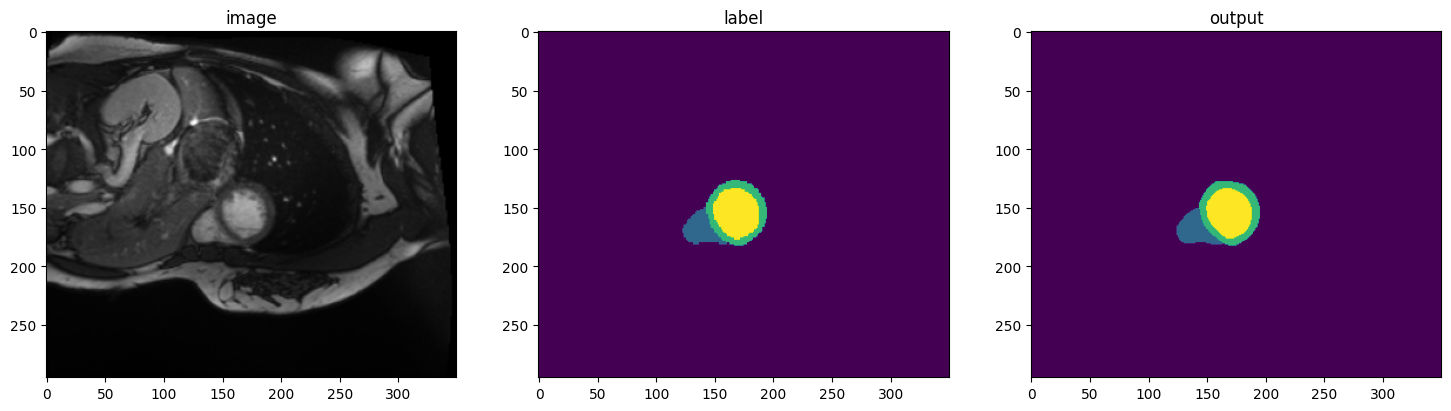

In [ ]:
root_dir = "/content/drive/MyDrive/Swin_UNETR_Vanila/"
case_num = 2
model.load_state_dict(torch.load(os.path.join(root_dir, "FDL_TransConv_ACDC_96*96_12May.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(val_inputs, (128, 128, 128), 1, model, overlap=0.8)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, 50], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, 50])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 50])
    plt.show()

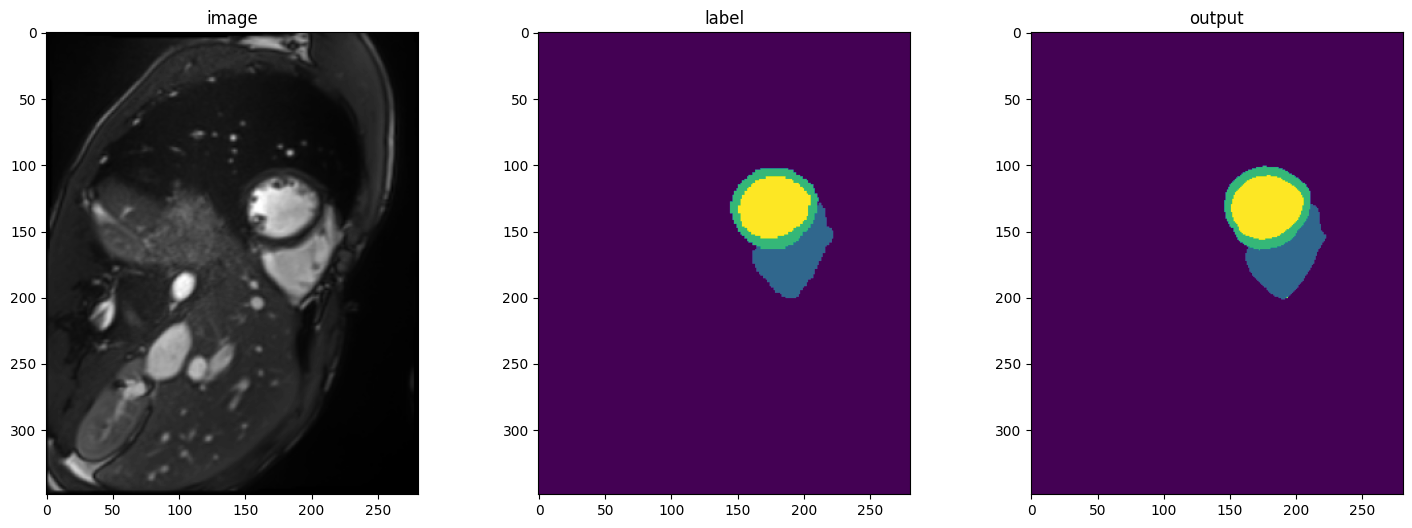

In [ ]:
root_dir = "/content/drive/MyDrive/Swin_UNETR_Vanila/"
case_num = 4
# model.load_state_dict(torch.load(os.path.join(root_dir, "FDL_TransConv_ACDC_96*96_12May.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(val_inputs, (128, 128, 128), 1, model, overlap=0.8)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, 50], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, 50])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 50])
    plt.show()

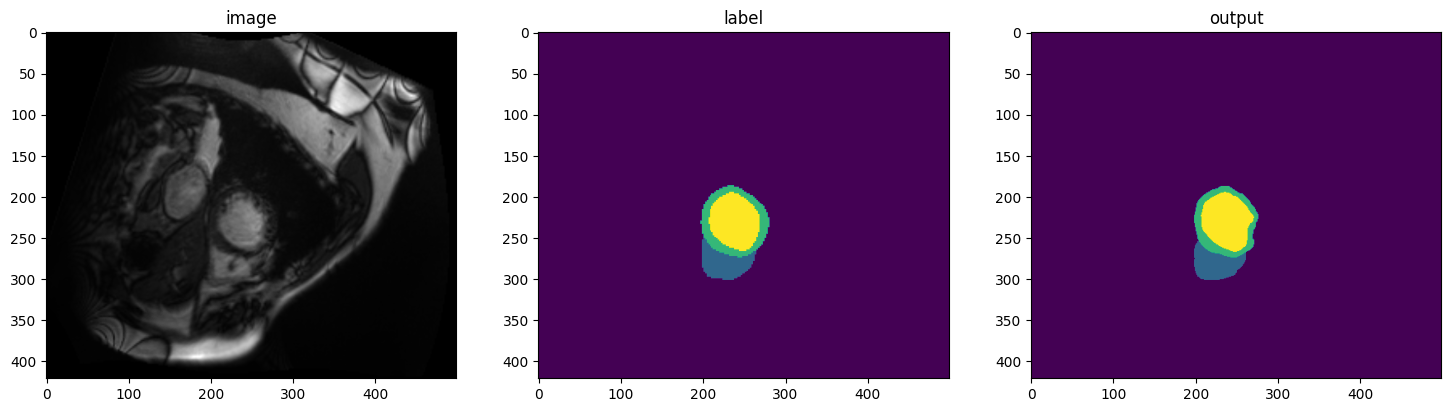

In [ ]:
root_dir = "/content/drive/MyDrive/Swin_UNETR_Vanila/"
case_num = 10
# model.load_state_dict(torch.load(os.path.join(root_dir, "FDL_TransConv_ACDC_96*96_12May.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(val_inputs, (128, 128, 128), 1, model, overlap=0.8)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, 50], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, 50])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 50])
    plt.show()

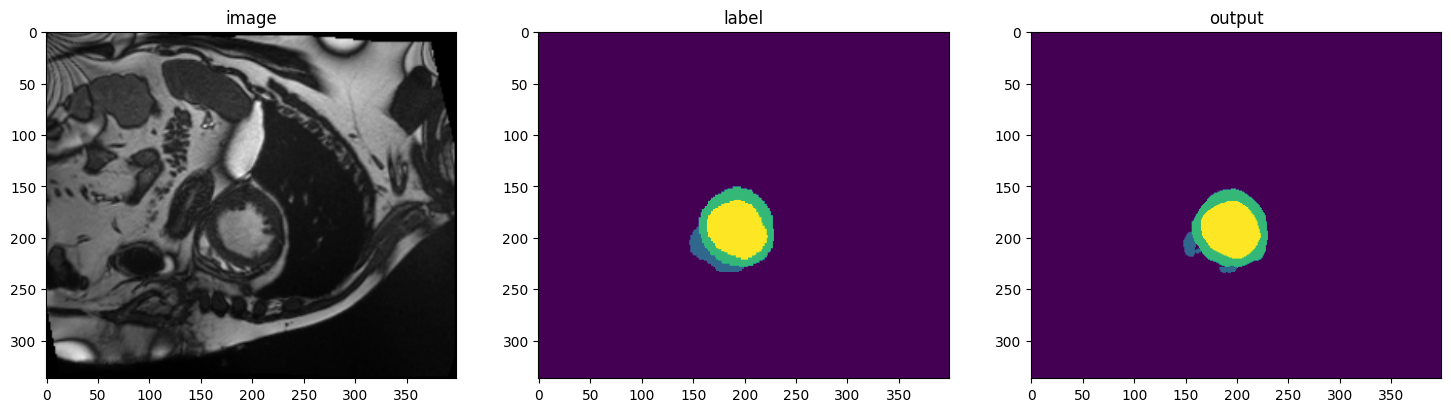

In [ ]:
root_dir = "/content/drive/MyDrive/Swin_UNETR_Vanila/"
case_num = 43
# model.load_state_dict(torch.load(os.path.join(root_dir, "FDL_TransConv_ACDC_96*96_12May.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(val_inputs, (128, 128, 128), 1, model, overlap=0.8)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, 50], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, 50])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 50])
    plt.show()